# REPORT: RECIPE SITE TRAFFIC


# Dataset Column Validation Steps

1. Determine number of missing values
2. Determine if there are any duplicate rows
3. Validate data types


In [1]:
state = 123

In [2]:
import pandas as pd

data_initial = pd.read_csv('recipe_site_traffic_2212.csv')
data_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


**Validation Step 1: Document Missing Values**
- Recipe: This appears to be an index column and therefore will be dropped before model training. So we can ignore this one.
- Calories: This column has 52 null values
- Carbohydrate: This column has 52 null values
- Sugar: This column has 52 null values
- Protein: This column has 52 null values
- Category: This column has no null values
- Servings: This column has no null values
- High Traffic: This column has 373 null values

In [3]:
## Check for duplicates
duplicated = data_initial.duplicated().sum()
print(duplicated)

0


**Validation Step 2: Determine Presence of Duplicate Rows**

There are no duplicate rows in this dataset

**Validation Step 3: Review Data Types**

- Recipe: No type change needed
- Calories: No type change needed
- Carbohydrate: No type change needed
- Sugar: No type change needed
- Protein: No type change needed
- Category: Change type from 'object' to 'category'
- Servings: Change type from 'object' to 'category'
- High Traffic: Change type from 'object' to 'category'

**********************************************************************************************************************************************************************************************************************************************

In [27]:
print(data_initial.describe())

           recipe     calories  carbohydrate       sugar     protein
count  825.000000   825.000000    825.000000  825.000000  825.000000
mean   472.812121   407.688170     31.409055    7.291115   20.536121
std    272.646130   384.873594     32.276337    8.876873   25.187473
min      2.000000     0.140000      0.030000    0.010000    0.000000
25%    236.000000   108.580000      8.310000    1.670000    3.120000
50%    475.000000   284.590000     20.860000    4.400000   10.550000
75%    708.000000   578.400000     43.200000    9.120000   28.550000
max    947.000000  1767.530000    163.330000   51.640000  132.870000


By running the describe() method on our data, we can observe that the maximum values of each column are significantly higher than their respective means. This raises the question of whether these values are part of the natural distribution or true outliers. The histogram below illustrates that the maximum value for calories does not even appear in the histogram. Additionally, the distributions of carbohydrates, protein, and sugar are quite similar. While the value of 3633.16 might align with the overall shape of the distribution, its deviation from the mean is so extreme that it does not appear visually, suggesting it may be an outlier. Mathematically, a value more than three standard deviations from the mean can be considered an outlier and removed. We will apply this approach to all four float columns.

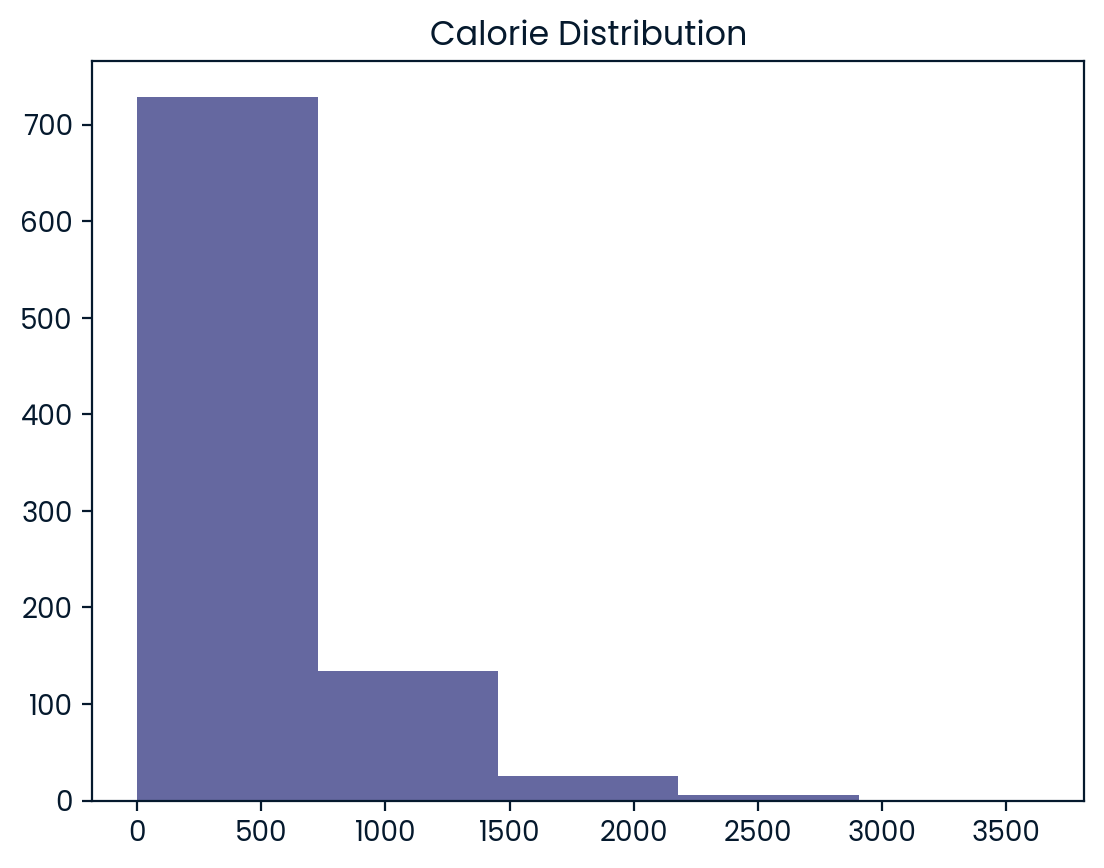

In [5]:
## Lets look at the distribution of the "calories" column. The max looks to be really far off the mean and the median. I'm looking to see if there are some "High caloric" recipes or if this one is a one off.
from matplotlib import pyplot as plt

plt.hist(data_initial.calories, bins = 5)
plt.title("Calorie Distribution")
plt.show()

In [6]:
## Get standard deviations to test for outliers in the float columns
columns = data_initial.columns
working_data = data_initial
for col in columns:
    if working_data.dtypes[col] == "float64":
        print(f"Cleaning {col}....")
        mean = working_data[col].mean()
        std = working_data[col].std()
        working_data = working_data[working_data[col] <= (mean + 3 * std)]
data_initial = working_data

Cleaning calories....
Cleaning carbohydrate....
Cleaning sugar....
Cleaning protein....


In [7]:
## Get value counts for the object columns

for col in data_initial.columns:
    if data_initial.dtypes[col] == 'object':
        print('***********************************')
        print(data_initial[col].value_counts())
        print('***********************************')

***********************************
Breakfast         105
Beverages          88
Chicken Breast     86
Lunch/Snacks       80
Vegetable          78
Potato             77
Meat               71
Pork               65
Chicken            62
One Dish Meal      58
Dessert            55
Name: category, dtype: int64
***********************************
***********************************
4               342
6               169
2               157
1               154
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64
***********************************
***********************************
High    486
Name: high_traffic, dtype: int64
***********************************


In [8]:
## Lets create a baseline dataset to train a baseline model with minimal adjustments
data_baseline = data_initial

## Fill in empty values in the 'high_traffic' column with 'Not High' and then replace 'High' and 'Not High' with 1 and 0 respectively.

## THIS IS AN ASSUMPTION I WILL NEED TO JOT DOWN: ASSUMED ALL BLANK VALUES IN THE 'high_traffic' COLUMN DID NOT HAVE ## HIGH TRAFFIC.
data_baseline['high_traffic'] = data_baseline['high_traffic'].fillna('Not High')
data_baseline['high_traffic'] = data_baseline['high_traffic'].replace({'High': '1', 'Not High': '0'})

## Lets also convert the object columns to category.
data_baseline = data_baseline.astype({'category': 'category', 'high_traffic': 'category', 'servings': 'category'})

## As there are only three rows that have the '4/6 as a snack' for a servings, I will replace them with just the integer part. With there only being three values, I do not believe this will affect the model too much. I will also convert the servings column to an 'int64' type
data_baseline['servings'] = data_baseline['servings'].replace({'4 as a snack': '4', '6 as a snack': '6'})

## Drop rows with missing values and the 'recipe' column.
data_baseline = data_baseline.dropna(how='any')
data_baseline = data_baseline.drop('recipe', axis=1)


## Check to make sure changes were applied.
print(data_baseline.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 825 entries, 1 to 946
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   calories      825 non-null    float64 
 1   carbohydrate  825 non-null    float64 
 2   sugar         825 non-null    float64 
 3   protein       825 non-null    float64 
 4   category      825 non-null    category
 5   servings      825 non-null    category
 6   high_traffic  825 non-null    category
dtypes: category(3), float64(4)
memory usage: 35.3 KB
None


# Data Cleaning Summary

Below, I provide a detailed log of the cleaning actions to every column:

Overall change: Dropped rows with any missing values

- Recipe:
    - Dropped
    
- Calories:
    - Dropped rows having >= mean + 3\*std
    
    
- Carbohydrate:
    - Dropped rows having >= mean + 3\*std
    
    
- Sugar:
    - Dropped rows having >= mean + 3\*std
    
    
- Protein:
    - Dropped rows having >= mean + 3\*std
    
    
- Category:
    - Changed data type from 'object' to 'category'
    
    
- Servings:
    - Changed '4/6 as a snack' to '4' and '6' respectively
    - Changed type from 'object' to 'category'
    
    
- High Traffic:
    - Changed all empty values to 'Not High'
    - Changed values 'High' and 'Not High' to '1' and '0' respectively
    - Changed data type from 'object' to 'category'

# Exploratory Data Analysis

Below, we compare different float values to examine how they vary between the two classes. Visually, the differences appear insignificant, and for each case except sugar, a t-test confirms that these differences likely have little effect on the class. For sugar, however, the variation in values is much smaller, as evident from the scale on the x-axis of the visual. This limited variation might explain why we can reject the null hypothesis in this case—the difference in means is somewhat magnified.

**T-test Results**

- Sugar
    - T-stat: -2.2670907436834016
    - p-Value: 0.023643334686922327
- Calories
    - T-stat: 1.7807289345872197
    - p-Value: 0.07532553304289515
- Carbohydrate
    - T-stat: 1.8265929277678343
    - p-Value: 0.06812309530046602
- Protein
    - T-stat: -0.018769655915748116
    - p-Value: 0.9850294099533559

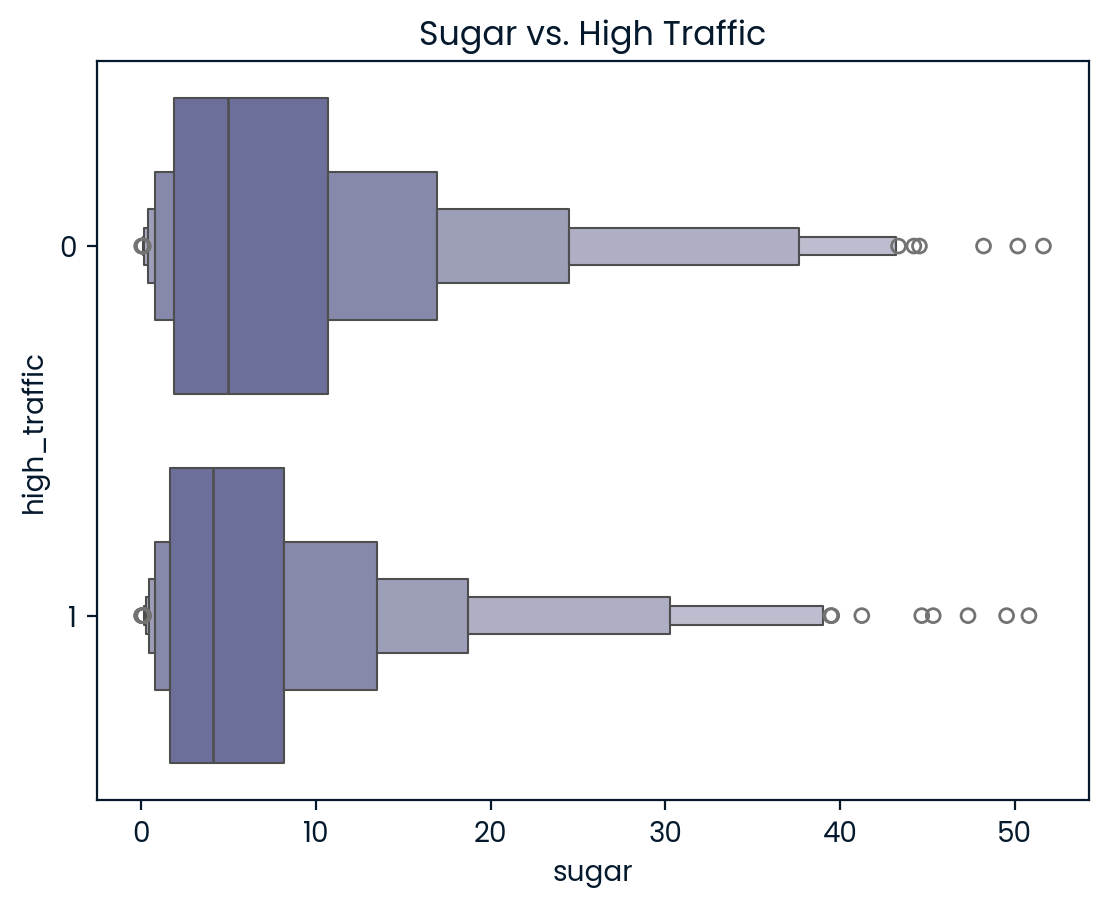

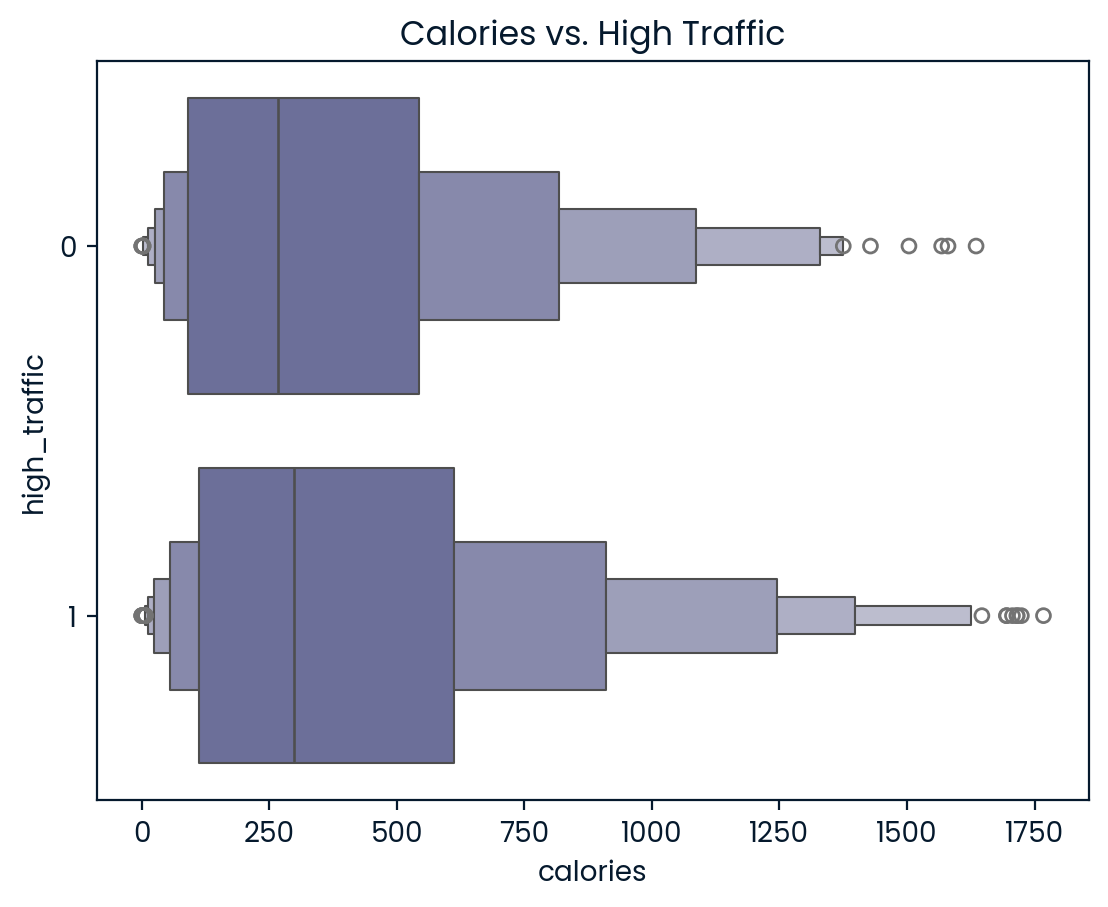

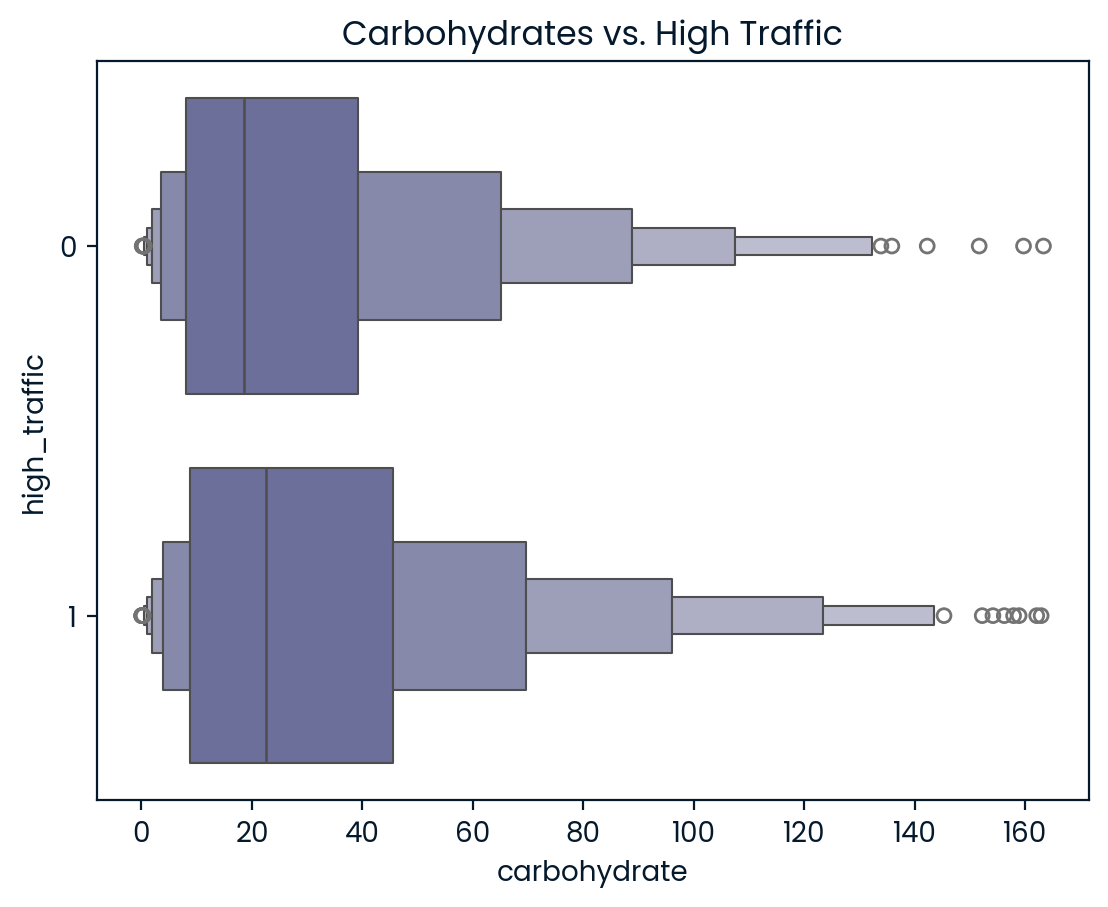

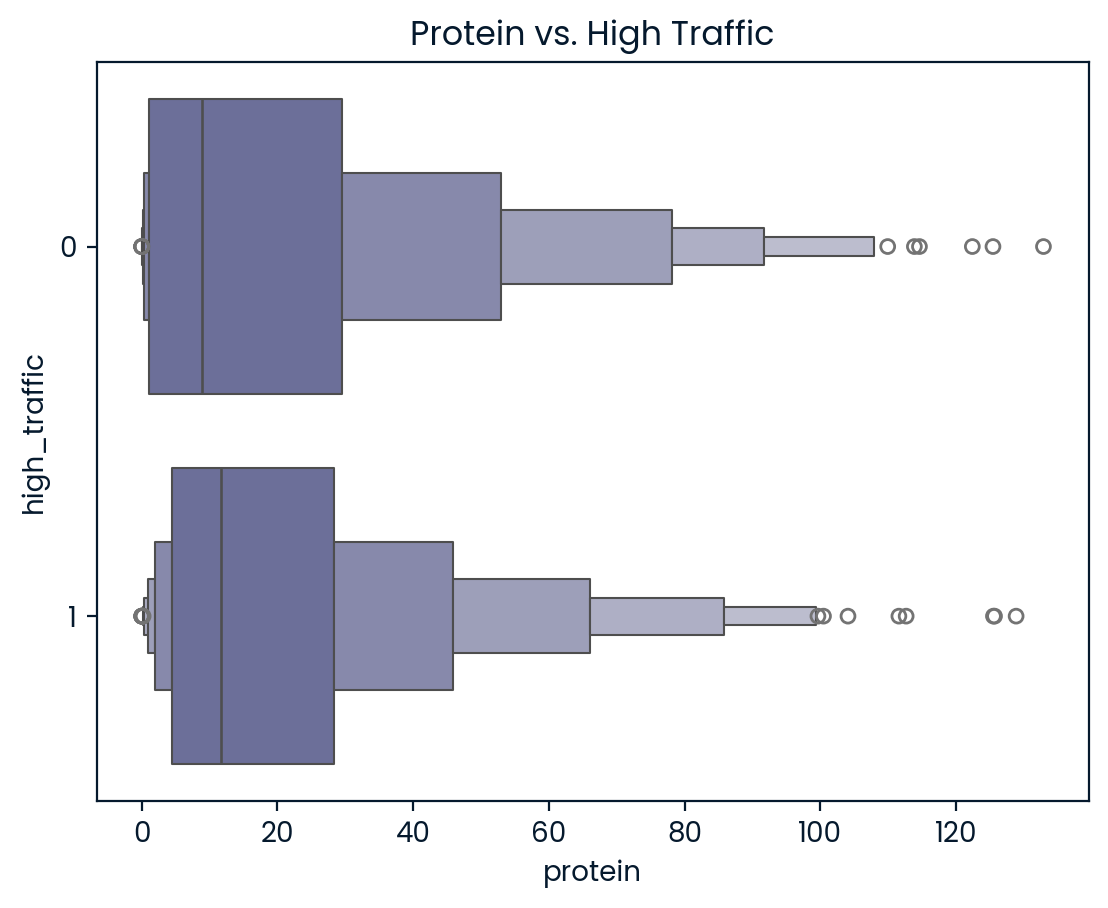

In [9]:
## Lets look at some pairs of columns to see how they relate to our target variable
import seaborn as sns

## Split data into high traffic and non-high traffic sets
data_high = data_baseline[data_baseline['high_traffic'] == '1']
data_low = data_baseline[data_baseline['high_traffic'] == '0']

## Lets look at sugar as it relates to high traffic
sns.boxenplot(data_baseline, x='sugar', y='high_traffic')
plt.title("Sugar vs. High Traffic")
plt.show()

## Lets also look at calories
sns.boxenplot(data_baseline, x='calories', y='high_traffic')
plt.title("Calories vs. High Traffic")
plt.show()

## Next Carbohydrates
sns.boxenplot(data_baseline, x='carbohydrate', y='high_traffic')
plt.title("Carbohydrates vs. High Traffic")
plt.show()

## Finally, Protein
sns.boxenplot(data_baseline, x='protein', y='high_traffic')
plt.title("Protein vs. High Traffic")
plt.show()

In [10]:
from scipy.stats import ttest_ind

columns = data_baseline.columns
for col in columns:
    if data_baseline.dtypes[col] == 'float64':
        t_stat, pval = ttest_ind(data_high[col], data_low[col])
        print(f"****************** Results for {col} ******************")
        print(f"t-stat: {t_stat}")
        print(f"p-value: {pval}")

****************** Results for calories ******************
t-stat: 1.7807289345872197
p-value: 0.07532553304289515
****************** Results for carbohydrate ******************
t-stat: 1.8265929277678343
p-value: 0.06812309530046602
****************** Results for sugar ******************
t-stat: -2.2670907436834016
p-value: 0.023643334686922327
****************** Results for protein ******************
t-stat: -0.018769655915748116
p-value: 0.9850294099533559


We can also examine how servings and meal categories affect the class. From the visual, it is evident that the category has a significant influence on determining the class of the recipe. For example, recipes in the "Beverage" category tend to generate low traffic, with only a few exceptions. Conversely, recipes in the "Vegetables" category generally attract high traffic, again with few exceptions.

In contrast, the distribution of the servings column does not differ significantly between the high and non-high traffic classes. While it is true that the high-traffic class contains more recipes across all serving categories, this primarily reflects the fact that the high-traffic class has more instances overall, as illustrated in the visual titled Balance of the Target Column Values. This does not suggest a statistically significant difference.

In conclusion, the rejection of the null hypothesis indicates that the difference in sugar means between the two classes is not due to chance (i.e., the sugar content in the high-traffic class does not belong to the same population as the sugar content in the non-high-traffic class). Therefore, sugar can be considered a statistically significant factor in determining the class. Additionally, while no statistical test was performed on the "Category" column, the visual comparison of Category vs. High Traffic strongly suggests a correlation between recipe categories and traffic class.


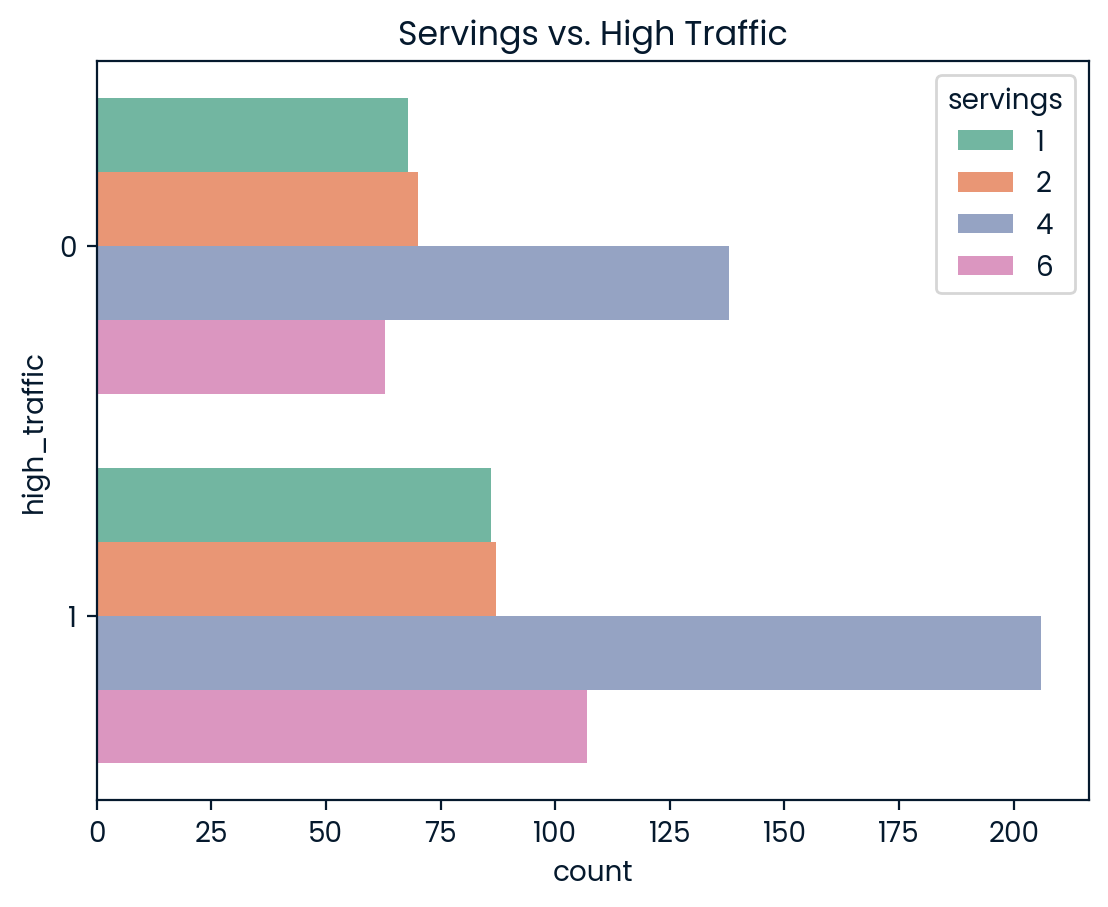

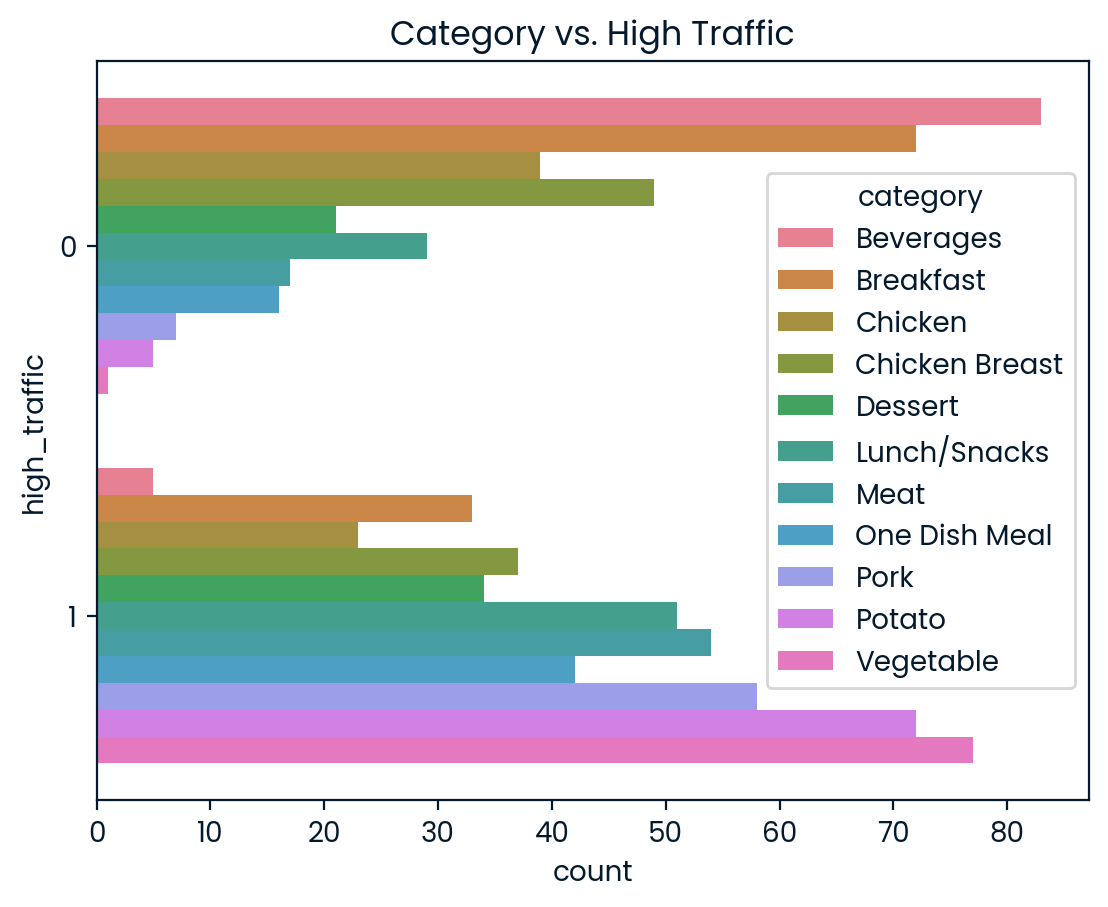

In [11]:
## Lets look at the relationship between Category, Servings and High traffic with a few different visuals


sns.set_palette('Set2')
sns.countplot(data_baseline, y='high_traffic', hue='servings')
plt.title('Servings vs. High Traffic')
plt.show()

sns.countplot(data_baseline, y='high_traffic', hue='category')
plt.title('Category vs. High Traffic')
plt.show()

<AxesSubplot: title={'center': 'Balance of Target Column Values'}>

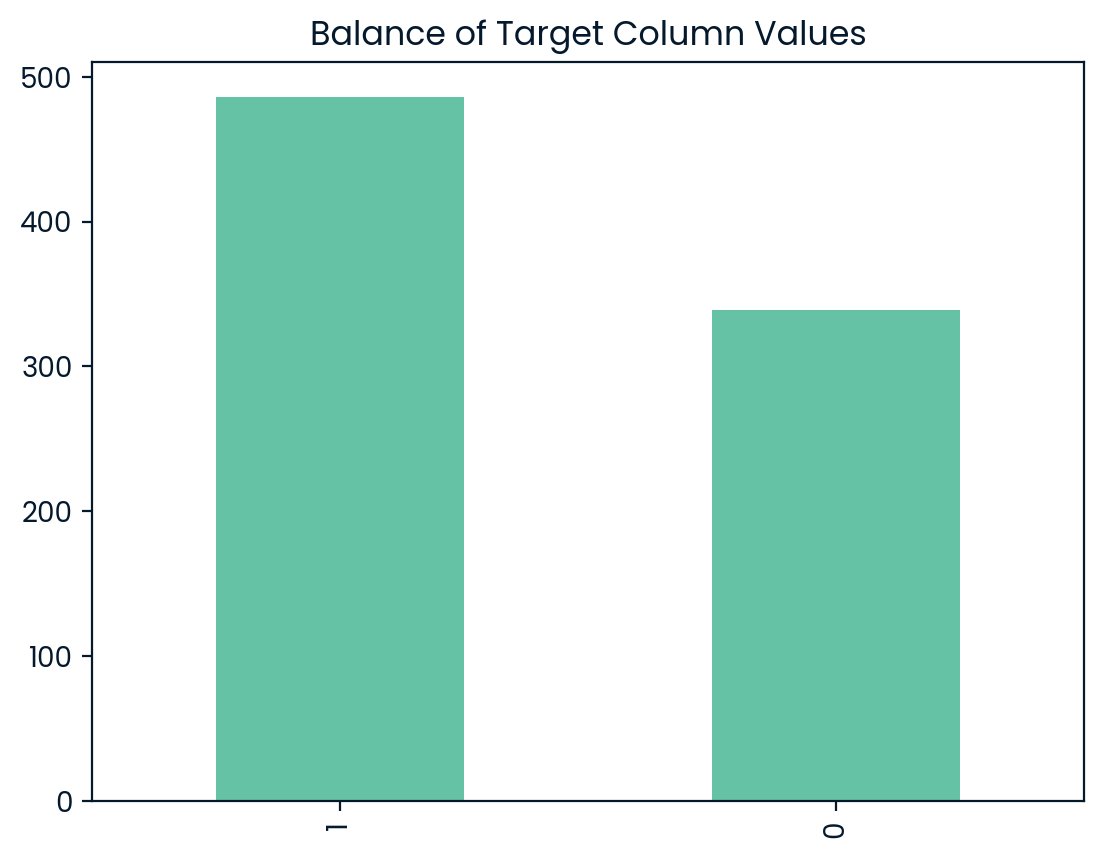

In [12]:
## Check balance of classes in our target variable column
data_initial.high_traffic.value_counts().plot(kind="bar", title="Balance of Target Column Values")

# Model Development

This is a binary classification problem, as the goal is to assign observations to one of two categories.

I chose Logistic Regression and Decision Tree Classifier as starting models due to their simplicity and effectiveness with small datasets. The evaluation metrics for these models are outlined below, along with the questions they address:

- Accuracy:  What percentage of predictions were correct?
- Precision: What percentage of predicted high-traffic recipes were actually high-traffic recipes?
- Recall: How many of the actual high-traffic recipes did the mdoel correctly predict?

## Baseline Logistic Regression Metrics

- Accuracy: 76%
- Precision: 78%
- Recall: 79%

## Baseline Decision Tree Classifier Metrics

- Accuracy: 65%
- Precision: 68%
- Recall: 70%

## Baseline Model Training Conclusion

The Logistic Regression model outperforms the Decision Tree Classifier across all tracked metrics and comes closest to our benchmark of correctly predicting high-traffic recipes 80% of the time.

Therefore, I will proceed with the Logistic Regression model.


In [13]:
## This is a classification problem as we want to be able to predict weather or not a recipe is going to draw high traffic to the website (class 1) or not (class 0). So we will need to try some classification algorithms.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

## Split the data into feature and target data
features = data_baseline.drop('high_traffic', axis=1)
target = data_baseline['high_traffic']

## Create dummy variables for the category columns in the features data
features = pd.get_dummies(features)

## Split the data into training and testing sets. Hold back 30% for testing
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=state)

## Instantiate and train the Logistic Regression model
log_reg = LogisticRegression(random_state = state)
log_reg.fit(x_train, y_train)

## Instantiate and train the Decision Tree model
tree = DecisionTreeClassifier(random_state = state)
tree.fit(x_train, y_train)

## Predict using the trained models
log_preds = log_reg.predict(x_test)
tree_preds = tree.predict(x_test)

## Print the accuracy scores of the two models
print(f'Log Regression Accuracy: {accuracy_score(y_pred=log_preds, y_true=y_test)}')
print(f'Decision Tree Accuracy: {accuracy_score(y_pred=tree_preds, y_true=y_test)}')



Log Regression Accuracy: 0.7620967741935484
Decision Tree Accuracy: 0.6491935483870968


In [14]:
## Check the types of errors each one is making with a confusion matrix

print('Log Regression Confusion Matrix')
print(confusion_matrix(y_true=y_test, y_pred=log_preds))

print('Decision Tree Confusion Matrix')
print(confusion_matrix(y_true=y_test, y_pred=tree_preds))



Log Regression Confusion Matrix
[[ 79  30]
 [ 29 110]]
Decision Tree Confusion Matrix
[[64 45]
 [42 97]]


In [15]:
## Compare the models on some other metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

## Precision: How many of the predicted high traffic were actually that?
log_precision = precision_score(y_true=y_test, y_pred=log_preds, pos_label='1')
tree_precision = precision_score(y_true=y_test, y_pred=tree_preds, pos_label='1')

print('Log Reg*****************************')
print(f"Out of all the high traffic predictions {np.round(log_precision * 100, 2)}% of them were actually high traffic recipes")
print('Decision Tree*****************************')
print(f'Out of all the high traffic predictions {np.round(tree_precision * 100, 2)}% of them were actually high traffic recipes')

## Recall: Out of all the high traffic recipes, how many did the model get?
log_recall = recall_score(y_true=y_test, y_pred=log_preds, pos_label='1')
tree_recall = recall_score(y_true=y_test, y_pred=tree_preds, pos_label='1')

print('Log Reg*****************************')
print(f"The model got {np.round(log_recall * 100, 2)}% of the high traffic recipes")
print('Decision Tree*****************************')
print(f'The model got {np.round(tree_recall * 100, 2)}% of the high traffic recipes')


Log Reg*****************************
Out of all the high traffic predictions 78.57% of them were actually high traffic recipes
Decision Tree*****************************
Out of all the high traffic predictions 68.31% of them were actually high traffic recipes
Log Reg*****************************
The model got 79.14% of the high traffic recipes
Decision Tree*****************************
The model got 69.78% of the high traffic recipes


## Comparison Models

### Logistic Regression: Hyperparameter Tuning

Using a `GridSearchCV` instance, I tuned the hyperparameters of the baseline model in an attempt to improve its performance. Unfortunately, the tuned model performed worse by comparison. While accuracy and precision were comparable, recall dropped by 1 percentage point. Although this is a minor difference, at best, the tuned model performed similarly to the baseline. Below are the rounded metrics:

- **Accuracy**: 76%  
- **Precision**: 78%  
- **Recall**: 78%

### Logistic Regression: Scaled Data

Next, I scaled the data using a `StandardScaler` object. However, this yielded the same results as hyperparameter tuning:

- **Accuracy**: 76%  
- **Precision**: 78%  
- **Recall**: 78%

### Logistic Regression: Oversampling with SMOTE

Since the target variable classes were imbalanced, I used SMOTE to oversample the "Not High" class to match the volume of the "High" class. Unfortunately, this approach also resulted in a model that underperformed compared to the others:

- **Accuracy**: 75%  
- **Precision**: 78%  
- **Recall**: 76%

### Best Logistic Regression Metrics

The baseline Logistic Regression model remained the best performer with:

- **Accuracy**: 76%  
- **Precision**: 78%  
- **Recall**: 79%

---

## Different Comparison Models

Since no improvements were achieved with the Logistic Regression model through tuning, scaling, or oversampling, I explored three additional models. Their accuracy scores are listed below:

- **Random Forest Classifier**: 71%  
- **K-Nearest Neighbors (KNN)**: 75%  
- **Gradient Boost Classifier**: 69%

The KNN algorithm yielded the best accuracy score, while the others performed significantly worse compared to the Logistic Regression model. Therefore, I proceeded with KNN. Since KNN performs best with scaled data, I created a pipeline to scale the data before fitting the algorithm.

### K-Nearest Neighbors: Hyperparameter Tuning

After performing a grid search on the KNN model, I slightly improved its accuracy and evaluated its precision and recall:

- **Accuracy**: 76%  
- **Precision**: 79%  
- **Recall**: 78%

These metrics are nearly identical to those of the baseline Logistic Regression model, except the precision and recall values are swapped.

### K-Nearest Neighbors: SMOTE Oversampling

To further improve the model, I applied SMOTE to oversample the minority class. Unfortunately, this yielded the same results as the tuned KNN model:

- **Accuracy**: 76%  
- **Precision**: 79%  
- **Recall**: 78%



In [16]:
## Tune the hyperparameters on the baseline model with grid search

from sklearn.model_selection import GridSearchCV

comp_logreg = log_reg

param_grid = {
                'C': [0.0001, 0.001, 0.01, 0.1, 1],
                'penalty': [None, 'l2', 'l1', 'elasticnet'],
                'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky'],
                'max_iter': [100, 200]
             }

search = GridSearchCV(comp_logreg, param_grid, scoring='accuracy', cv=5)

search.fit(features, target)

best_model = search.best_estimator_

print(f'Best accuracy: {search.best_score_}')
print(f'Best parameters: {search.best_params_}')

Best accuracy: 0.7612121212121211
Best parameters: {'C': 0.0001, 'max_iter': 100, 'penalty': None, 'solver': 'lbfgs'}


In [17]:
best_model.fit(x_train, y_train)

best_preds = best_model.predict(x_test)

print("Accuracy:", accuracy_score(y_true=y_test, y_pred=best_preds))
print("Precision:", precision_score(y_true=y_test, y_pred=best_preds, pos_label='1'))
print("Recall:", recall_score(y_true=y_test, y_pred=best_preds, pos_label='1'))

Accuracy: 0.7580645161290323
Precision: 0.7841726618705036
Recall: 0.7841726618705036


In [18]:
## Scale data with StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_data = scaler.fit_transform(features)
scaled_x_train, scaled_x_test, scaled_y_train, scaled_y_test = train_test_split(scaled_data, target, test_size=0.3, random_state=state)

In [19]:
search = GridSearchCV(comp_logreg, param_grid, scoring='accuracy', cv=5)

search.fit(scaled_data, target)

scaled_best_model = search.best_estimator_

print(f'Best accuracy: {search.best_score_}')
print(f'Best parameters: {search.best_params_}')

Best accuracy: 0.76
Best parameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}


In [20]:
best_model.fit(x_train, y_train)

scaled_best_model_pred = best_model.predict(x_test)

print("Accuracy:", accuracy_score(y_true=y_test, y_pred=scaled_best_model_pred))
print("Precision:", precision_score(y_true=y_test, y_pred=scaled_best_model_pred, pos_label='1'))
print("Recall:", recall_score(y_true=y_test, y_pred=scaled_best_model_pred, pos_label='1'))

Accuracy: 0.7580645161290323
Precision: 0.7841726618705036
Recall: 0.7841726618705036


In [21]:
## We will try a few other learning algorithms to see if we can do any better on the accuracy
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

rfc = RandomForestClassifier()
knn = KNeighborsClassifier(n_neighbors=5)
gbc = GradientBoostingClassifier()

rfc.fit(x_train, y_train)
knn.fit(scaled_x_train, scaled_y_train)
gbc.fit(x_train, y_train)

rfc_preds = rfc.predict(x_test)
knn_preds = knn.predict(scaled_x_test)
gbc_preds = gbc.predict(x_test)

print(f'Random Forest accuracy: {accuracy_score(y_true=y_test, y_pred=rfc_preds)}')
print(f'KNN accuracy: {accuracy_score(y_true=scaled_y_test, y_pred=knn_preds)}')
print(f'Gradient Boost accuracy: {accuracy_score(y_true=y_test, y_pred=gbc_preds)}')


Random Forest accuracy: 0.7056451612903226
KNN accuracy: 0.7459677419354839
Gradient Boost accuracy: 0.6895161290322581


In [22]:
knn_params = {
                'n_neighbors': [5, 10, 15, 20, 50],
                'weights': ['uniform','distance'],
                'algorithm': ['auto','ball_tree','kd_tree','brute']
             }

search = GridSearchCV(knn, knn_params, scoring='accuracy', cv=5)

search.fit(scaled_data, target)

best_knn = search.best_estimator_

best_knn_preds = best_knn.predict(scaled_x_test)

print("Accuracy:", accuracy_score(y_true=scaled_y_test, y_pred=best_knn_preds))
print("Precision:", precision_score(y_true=scaled_y_test, y_pred=best_knn_preds, pos_label='1'))
print("Recall:", recall_score(y_true=scaled_y_test, y_pred=best_knn_preds, pos_label='1'))


Accuracy: 0.7620967741935484
Precision: 0.7941176470588235
Recall: 0.7769784172661871


In [23]:
## As KNN performs better with scaled data lets make a pipeline
from sklearn.pipeline import Pipeline

steps = [
            ('scaler', StandardScaler()),
            ('knn', best_knn)
        ]

knn_pipe = Pipeline(steps)

In [24]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=state)

x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_smote))


Before SMOTE: Counter({'1': 347, '0': 230})
After SMOTE: Counter({'1': 347, '0': 347})


In [25]:
knn_smote = knn_pipe.fit(x_train_smote, y_train_smote)
knn_smote_preds = knn_smote.predict(scaled_x_test)

print("Accuracy:", accuracy_score(y_true=scaled_y_test, y_pred=knn_smote_preds))
print("Precision:", precision_score(y_true=scaled_y_test, y_pred=knn_smote_preds, pos_label='1'))
print("Recall:", recall_score(y_true=scaled_y_test, y_pred=knn_smote_preds, pos_label='1'))

Accuracy: 0.7620967741935484
Precision: 0.7941176470588235
Recall: 0.7769784172661871


In [26]:
log_reg_smote = log_reg

log_reg_smote.fit(x_train_smote, y_train_smote)

log_reg_smote_pred = log_reg_smote.predict(x_test)

print("Accuracy with SMOTE:", accuracy_score(y_true=y_test, y_pred=log_reg_smote_pred))
print("Precision with SMOTE:", precision_score(y_true=scaled_y_test, y_pred=log_reg_smote_pred, pos_label='1'))
print("Recall with SMOTE:", recall_score(y_true=scaled_y_test, y_pred=log_reg_smote_pred, pos_label='1'))

Accuracy with SMOTE: 0.7459677419354839
Precision with SMOTE: 0.7835820895522388
Recall with SMOTE: 0.7553956834532374


# Model Evaluation

Ultimately, we have two models that are comparable: the baseline Logistic Regression model and the K-Nearest Neighbor (KNN) algorithm. Below are their best metrics for direct comparison:

### Baseline Logistic Regression Metrics

- **Accuracy**: 76%  
- **Precision**: 78%  
- **Recall**: 79%

### Tuned K-Nearest Neighbor Metrics

- **Accuracy**: 76%  
- **Precision**: 79%  
- **Recall**: 78%

The goal of this project was to predict high-traffic recipes and correctly identify them 80% of the time. In this context, the recall metric aligns closely with this objective, as it measures how many of the high-traffic recipes our model correctly predicts. While accuracy is a strong leading metric for evaluation (as recall often improves with increased accuracy), recall serves as an excellent tie-breaker in this project.  

Precision, however, should not be overlooked. When selecting recipes to feature on the website, it is crucial to be confident in the model's high-traffic predictions. Precision answers this question directly: how confident can we be when the model predicts that a recipe will attract high traffic?

# Business Metrics

The business should continue to collect data, as this will help improve the model's performance over time. While doing so, it is essential to monitor the model's precision. A decline in precision may indicate that the model needs retraining due to changes in external factors. Below are the steps required to track precision:

1. Post the model's recommended recipes on the website.  
2. When it is time to rotate the recipes, record which ones attracted high traffic and which did not.  
3. At the end of a specified time period (I recommend at least one week), calculate precision by dividing the number of high-traffic recipes by the total number of recipes posted on the homepage.  
4. Repeat steps 1–3 for subsequent time periods.  

If precision ever drops below **60%**, the data team should be alerted immediately. A precision rate below 60% suggests the model is performing only marginally better than random guessing, indicating the potential need for retraining with updated data.


# Final Recommendations

I recommend that the business move forward with the K-Nearest Neighbor (KNN) model. Due to its additional percentage point in precision, we can have greater confidence in its positive predictions. Additionally, its accuracy matches that of the Logistic Regression model, and its recall is within one percentage point. I am confident that this model will yield results consistent with the goals of this project.

Furthermore, I recommend that the business continue collecting data on the model for ongoing evaluation. This is not only important for monitoring but also because more data translates to more information, which can potentially improve the model's metrics as we strive to maximize evaluation performance.

I also recommend implementing the procedure outlined in the Business Metrics section as a routine part of posting new recipes to the homepage. This will help build a robust historical dataset for the purposes mentioned above.

In conclusion, while the model falls slightly short of our target of predicting high-traffic recipes 80% of the time, I am confident that it can still provide valuable suggestions for homepage recipes. Provided that the recommended procedures are implemented, I am optimistic that we can continue to enhance the model's effectiveness in predicting high-traffic recipes.